# **Problème du secrétaire**
#### ***Séminaire de Modélisation Statistique - 2A ENSAE***

## 1. Cadre du problème

Dans le cadre du Séminaire de Modélisation Statistique, nous avons assisté à **une intervention de Vianney Perchet (CREST, Criteo) sur les algorithmes de matching**. Nous avons souhaité travailler sur **le problème du secrétaire** aussi appelé la « règle des 37 % » qui nous avait été présenté en interlude.

Le problème du secrétaire est le suivant : étant donné n nombres qui arrivent les uns après les autres et dans un ordre aléatoire, quelle est **la stratégie qui maximise la probabilité de sélectionner le plus élevé** ? Ce problème tient au fait que la décision d’accepter ou non un nombre doit être faite immédiatement et de manière irrévocable, sans connaître les nombres qui arrivent par la suite.

Une **stratégie naïve** serait de sélectionner le premier nombre : la probabilité que ça soit le plus élevé est de 1/n ! Cependant, **on peut maximiser cette probabilité** jusqu’à **la constante 1/e, au moins** : il s’agit alors d’observer un échantillon composé des n/e premiers nombres (soit 37 % des nombres) puis de sélectionner ensuite le premier nombre supérieur au maximum de l’échantillon. Avec cette stratégie, si le maximum est dans l’échantillon, alors on sélectionne le dernier nombre et on a perdu. En revanche, si le maximum n’est pas dans l’échantillon mais que le deuxième plus grand y est, alors on a gagné.

Nous souhaitons **introduire des contraintes à ce problème** afin de **redéfinir la stratégie optimale qui permet de maximiser la probabilité de sélectionner le (ou les) meilleur(s) candidat(s)**. En effet, un cas d’usage du problème du secrétaire est **le recrutement** : les candidats peuvent être représentés par des nombres qui reflètent un niveau de compétence, par exemple. Or, dans la réalité, les entreprises composent aussi avec **des contraintes de diversité ou budgétaires**. De fait, il y a un **coût d’opportunité** à ne pas avoir de diversité (l’entreprise perd en créativité, la marque employeur est affectée, etc.) ou à recruter un candidat avec des prétentions salariales trop fortes (inégalités salariales dans l’entreprise, moins de capacité de recrutement pour les prochains besoins).

## 2. Etat de l'art

### 2.1. Démonstration du problème du secrétaire

*L'objectif de cette section est de montrer empiriquement la règle des 37 %. Pour la démonstration mathématique, nous vous invitons à vous référer à l'article suivant : "La loi du 1/e" (Carine Bartholmé, 2011)*

Lien de l'article : https://bssm.ulb.ac.be/data/books/Bssm-2011-Carine-Bartholme.pdf

In [1]:
import numpy as np

def generate_candidates(n):
    candidates = np.arange(1, n + 1)
    np.random.shuffle(candidates)
    return list(candidates)

Pour nos n candidats, **on rejette les int(round(n/np.e)) premiers** : ils constituent **un échantillon**. On retient le premier candidat avec un meilleur niveau que le meilleur de notre échantillon (d'où l'index 0 dans chosen_candidate = better_candidates[0]). S'il n'y en a pas (parce que le meilleur candidat est dans notre échantillon), alors on retient le dernier candidat.

In [2]:
def choose_candidate(candidates: list, prop = 1 / np.e):
    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = np.min(candidates[:sample_size])
    other_candidates = candidates[sample_size:]
    better_candidates = [candidate for candidate in other_candidates if candidate <= best_from_sample]
    if len(better_candidates) > 0:
        chosen_candidate = better_candidates[0]
    else:
        chosen_candidate = other_candidates[-1]
    return chosen_candidate

In [9]:
choose_candidate(generate_candidates(100), 1 / np.e)

1

On réalise 100 000 simulations pour 100 candidats et on trace les courbes de fréquence avec Matplotlib.
On constate que cette stratégie permet de sélectionner fréquemment le meilleur candidat : environ 37 000 fois sur 100 000 (soit **37 % du temps**).

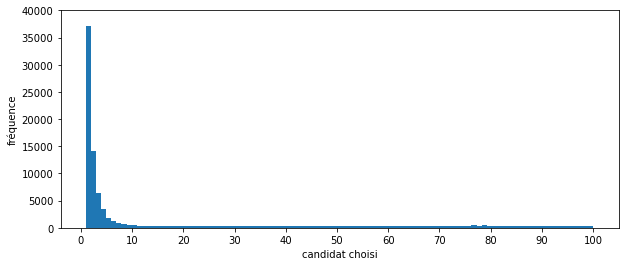

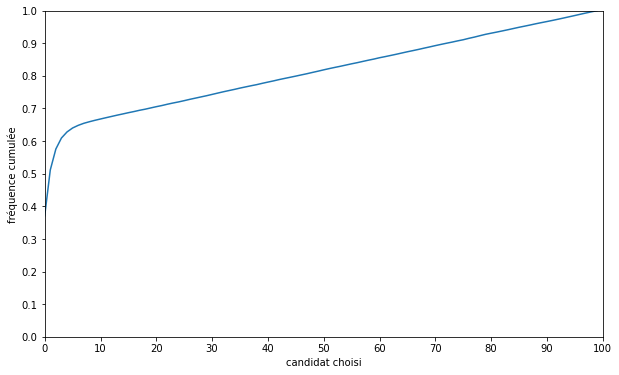

In [10]:
import matplotlib.pyplot as plt 

sim = np.array([choose_candidate(generate_candidates(n = 100)) for i in range(100000)])
plt.figure(figsize = (10, 4))
plt.hist(sim, bins = 100)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 40000)
plt.xlabel('candidat choisi')
plt.ylabel('fréquence')
plt.show()

# graphe pour obtenir la fréquence cumulée du choix du meilleur candidat

plt.figure(figsize = (10, 6))
plt.plot(np.cumsum(np.histogram(sim, bins = 100)[0]) / 100000)
plt.ylim(0,1)
plt.xlim(0, 100)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 101, 10))
plt.xlabel('candidat choisi')
plt.ylabel('fréquence cumulée')
plt.show()

On cherche à déterminer empiriquement la proportion optimale de candidat à intégrer à l'échantillon. Pour cela, on calcule les fréquences moyennes du choix du meilleur candidat en fonction de la proportion.

processing: 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


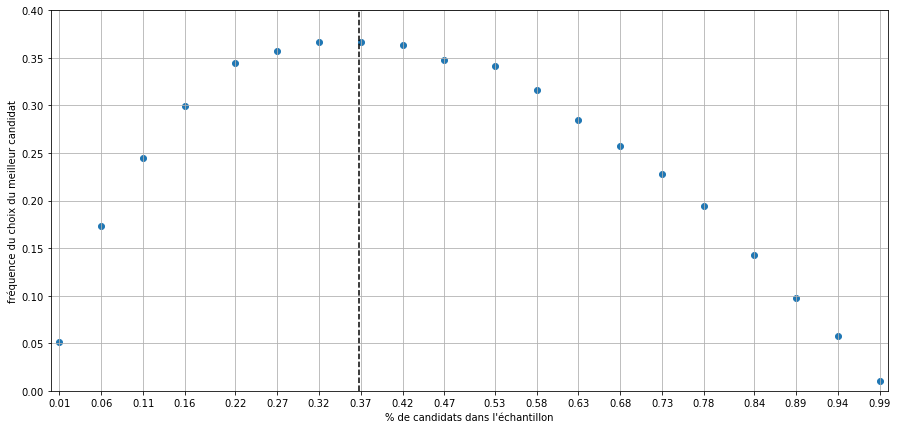

In [11]:
from tqdm import tqdm

props = [np.round(prop, 2) for prop in list(np.linspace(0.01, 0.99, num = 20))]
freq_best_candidate = []
for prop in tqdm(props, "processing"):
    sim = [choose_candidate(generate_candidates(100), prop) for i in range(10000)]
    freq_best_candidate.append(np.histogram(sim, bins = 100)[0][0] / 10000)

plt.figure(figsize=(15, 7))
plt.scatter(props, freq_best_candidate)
plt.xlim(0, 1)
plt.xticks(props)
plt.ylim(0, 0.4)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("fréquence du choix du meilleur candidat")
plt.grid(True)
plt.axvline(1 / np.e, ls = '--', c = 'black')
plt.show()

On constate que c'est bien avec une stratégie où on intègre 37 % des candidats dans l'échantillon (soit 1/e) qu'on maximise la probabilité de tirer le meilleur candidat.

On peut cependant **modifier la stratégie** : on veut **retenir un des k meilleurs candidats**.

processing for 10 best candidates: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]


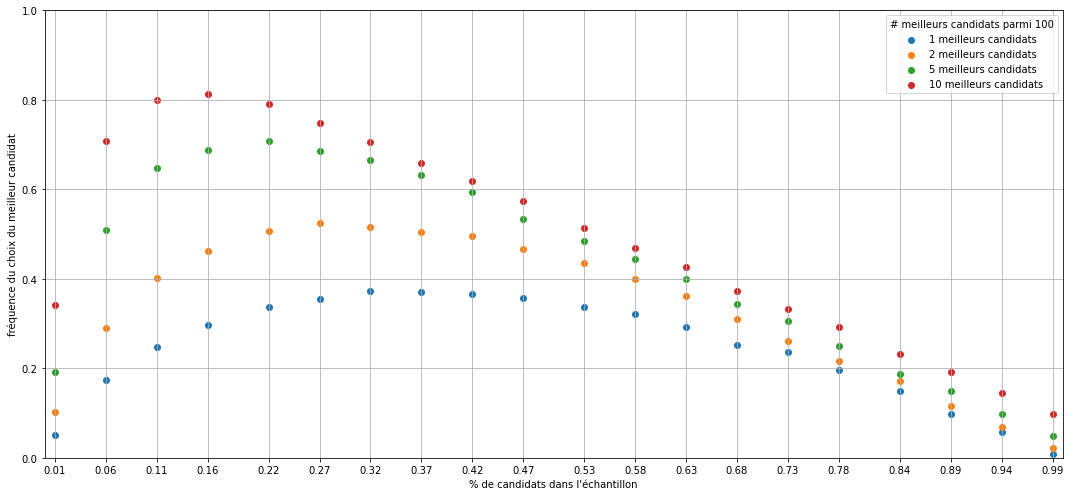

In [12]:
props = [np.round(prop, 2) for prop in list(np.linspace(0.01, 0.99, num = 20))]

plt.figure(figsize = (15, 7))
for k in [1, 2, 5, 10]:
    number_of_candidates = 100
    freq_best_candidate = []
    for prop in tqdm(props, f"processing for {k} best candidates"):
        sim = np.array([choose_candidate(generate_candidates(number_of_candidates), prop) for i in range(10000)])
        freq_best_candidate.append(len(sim[sim <= k]) / 10000)
    plt.scatter(props, freq_best_candidate, label = str(k) + f" meilleurs candidats")
plt.xlim(0, 1)
plt.xticks(props)
plt.ylim(0, 1)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("fréquence du choix du meilleur candidat")
plt.legend(title = f'# meilleurs candidats parmi {number_of_candidates}')
plt.grid(True)
plt.tight_layout()
plt.show()

On observe alors qu'en fonction du nombre de l'exigence du recrutement (on est prêt à accepter le k-ième meilleur candidat), **la stratégie évolue** : on ne compose plus un échantillon de 37 % des candidats mais de moins. 

Ainsi, on peut obtenir une probabilité de plus de 80 % en composant un échantillon de 15 % des candidats environ si on est prêt à accepter un des dix meilleurs candidats parmi 100.

### 2.2. k-Secretary-Problem

On s'intéresse dans cette section au **k-Secretary Problem**. L'objectif n'est plus de sélectionner le meilleur candidat mais **k candidats qui minimisent une fonction objectif convexe** (la somme des rangs des candidats, par exemple).

On distingue deux stratégies décrites dans l'article de Babaioff, Immorlica et al. (Cornell) : virtual et optimistic.
On compare les performances de ces deux stratégies.

Lien vers article : https://www.cs.cornell.edu/~rdk/papers/approx07.pdf

**Explication de la stratégie virtual pour $k = 2$ et $n$ candidats** :

Soit la fonction objectif convexe $F$ (somme des rangs) et $n$ candidats

1) On retient d'abord dans notre échantillon de taille $k$ $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) Ensuite, on parcourt les candidats restant $R = (z_{k+1} ... z_{n})$ pour remplir $res$ notre couple de candidats retenus : 
- pour chaque candidat $z_{i}$, on compare avec $y^{\star}$.
- si $z_{i} \leq y^{\star}$ alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(x^{\star},z_{1}^{\star}), max(x^{\star},z_{1}^{\star}) ) $ ;
    - on poursuit en comparant $z_{i+1}$ avec $max(x^{\star},z{1}^{\star})$
    - si $z_{i+1} \leq max(x^{\star},z_{1}^{\star})$ alors on retient $z_{2}^{\star} = z_{i+1}$ que l'on ajoute à $res$
    - sinon on continue avec $z_{i+2}$
    - on obtient $res = (z_{1}^{\star},z_{2}^{\star})$
- sinon, on passe à $z_{i+1}$


3) si on arrive au dernier candidat, alors on retient $res = (z_{1}^{\star},z_{n})$ ou $res = (z_{n-1},z_{n})$ si on n'a pas trouvé de $z_{i} \leq y^{\star}$.

In [29]:
# Virtual strategy

def virtual_choose_k_candidates(candidates, prop, k):
    
    # on définit notre échantillon et on retient les k meilleurs de notre échantillon
    # ces k meilleurs minimisent notre fonction objectif (somme des rangs)
    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = sorted(sample)[:k]
    #print("best_from_sample :")
    #display(best_from_sample)
    
    other_candidates = candidates[sample_size:]
    chosen_candidates = []
    remaining_candidates = len(other_candidates)
    #print(f"remaining_candidates : {remaining_candidates}")

    for x in other_candidates:
        # si on a encore des candidats à choisir
        if len(chosen_candidates) < k:
            # s'il reste suffisamment de candidats à voir
            if remaining_candidates > k - len(chosen_candidates):
                # si le candidat observé est meilleur que le moins bons des candidats retenus dans l'échantillon
                if x < best_from_sample[-1]:
                    # alors on le choisit
                    chosen_candidates.append(x)
                    #print("chosen_candidates :")
                    #display(chosen_candidates)
                    # on remplace le moins bons des candidats retenus dans l'échantillon par ce candidat
                    best_from_sample[-1] = x
                    # on refait un tri
                    # cela permet de comparer le candidat suivant avec le moins bon des meilleurs candidats observés
                    best_from_sample = sorted(best_from_sample)
                    #print("best_from_sample :")
                    #display(best_from_sample)
            else:
                chosen_candidates.append(x)
            remaining_candidates -= 1
            #print(remaining_candidates)
        else:
            return chosen_candidates
    
    return chosen_candidates

number_of_candidates = 1000
k = 10
sample_size = 0.37
candidates = generate_candidates(number_of_candidates)
max_score = sum(sorted(generate_candidates(number_of_candidates))[:k])
display(f"max_score is {max_score} for {k} best candidates amongst {number_of_candidates}")
chosen_candidates = virtual_choose_k_candidates(candidates, sample_size, k)
print(f"virtual_algo_score is {sum(chosen_candidates)} for {k} best candidates amongst {number_of_candidates}")
print("chosen_candidates :")
display(chosen_candidates)

'max_score is 55 for 10 best candidates amongst 1000'

virtual algo_score is 119 for 10 best candidates amongst 1000
chosen_candidates :


[24, 23, 3, 13, 12, 18, 14, 5, 6, 1]

On observe **la fréquence des scores** obtenus avec la stratégie virtual sachant que le score minimal est :

$$\frac{n(n+1)}{2}$$

avec $n$ le nombre de candidats.

on se place dans le cas où on sélectionne 10 candidats parmi 100 avec une taille d'échantillon de 0.37
on effectue 10000 simulations


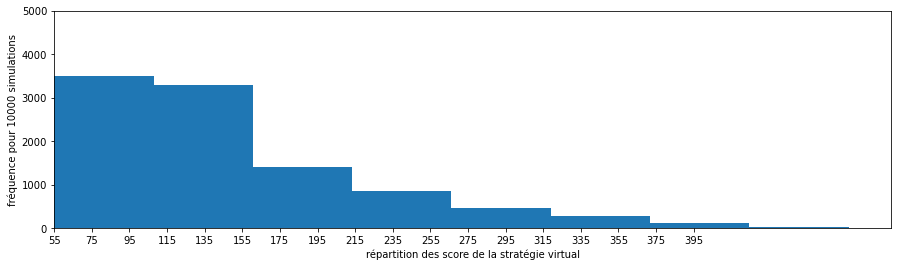

In [26]:
number_of_candidates = 100
k = 10
sample_size = 0.37
print(f"on se place dans le cas où on sélectionne {k} candidats parmi {number_of_candidates} avec une taille d'échantillon de {sample_size}")
print(f"on effectue {n_sim} simulations")
n_sim = 10000
sim = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), sample_size, k)) for i in range(n_sim)])
plt.figure(figsize = (15, 4))
plt.hist(sim, bins = 10)
plt.xticks(np.arange(55, 400, 20))
plt.ylim(0, 5000)
plt.xlim(55, 500)
plt.xlabel('répartition des score de la stratégie virtual')
plt.ylabel(f'fréquence pour {n_sim} simulations')
plt.show()

On cherche la **taille optimale de l'échantillon** avec la stratégie virtual.

processing through props: 100%|██████████| 20/20 [00:48<00:00,  2.41s/it]


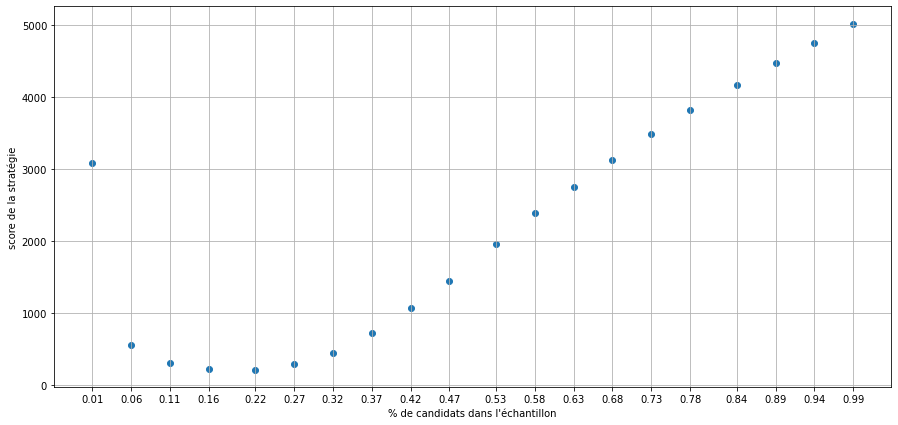

In [27]:
from tqdm import tqdm
number_of_candidates = 1000
k = 10

props = [np.round(prop, 2) for prop in list(np.linspace(k / number_of_candidates, 1 - k / number_of_candidates, num = 20))]
score_virtual = []
for prop in tqdm(props, "processing through props"):
    sim_virtual = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(10000)])
    score_virtual.append(np.mean(sim_virtual))

plt.figure(figsize = (15, 7))
plt.scatter(props, score_virtual)
plt.xticks(props)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("score de la stratégie")
plt.grid(True)
plt.show()

**Explication de la stratégie optimistic pour $k = 2$ et $n$ candidats** : # pas fini 

Soit la fonction objectif convexe $F$ (somme des rangs) et $n$ candidats

1) Comme dans la stratégie vitual, on retient d'abord dans notre échantillon de taille $k$ $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) Ensuite, on parcourt les candidats restant $R = (z_{k+1} ... z_{n})$ pour remplir $res$ notre couple de candidats retenus : 
- pour chaque candidat $z_{i}$, on compare avec $y^{\star}$.
- si $z_{i} \leq y^{\star}$ alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(x^{\star},z_{1}^{\star}), max(x^{\star},z_{1}^{\star}) ) $ ;
    - on poursuit en comparant $z_{i+1}$ avec $max(x^{\star},z{1}^{\star})$
    - si $z_{i+1} \leq max(x^{\star},z_{1}^{\star})$ alors on retient $z_{2}^{\star} = z_{i+1}$ que l'on ajoute à $res$
    - sinon on continue avec $z_{i+2}$
    - on obtient $res = (z_{1}^{\star},z_{2}^{\star})$
- sinon, on passe à $z_{i+1}$


3) si on arrive au dernier candidat, alors on retient $res = (z_{1}^{\star},z_{n})$ ou $res = (z_{n-1},z_{n})$ si on n'a pas trouvé de $z_{i} \leq y^{\star}$.

In [41]:


def optimistic_choose_k_candidates(candidates, prop, k):

    sample_size = int(round(len(candidates) * prop))
    sample = candidates[:sample_size]
    best_from_sample = sorted(sample)[:k]

    other_candidates = candidates[sample_size:]
    chosen_candidates = []
    remaining_candidates = len(other_candidates)

    for x in other_candidates:
        if len(chosen_candidates) < k:
            if remaining_candidates > k - len(chosen_candidates):
                if x < best_from_sample[-1]:
                    chosen_candidates.append(x)
                    del best_from_sample[-1]
            else:
                chosen_candidates.append(x)
            remaining_candidates -= 1
        else:
            return chosen_candidates
    
    return chosen_candidates

number_of_candidates = 1000
k = 10
sample_size = 0.37
candidates = generate_candidates(number_of_candidates)
max_score = sum(sorted(generate_candidates(number_of_candidates))[:k])
display(f"max_score is {max_score} for {k} best candidates amongst {number_of_candidates}")
chosen_candidates = optimistic_choose_k_candidates(candidates, sample_size, k)
print(f"optimistic_algo_score is {sum(chosen_candidates)} for {k} best candidates amongst {number_of_candidates}")
print("chosen_candidates :")
display(chosen_candidates)

'max_score is 55 for 10 best candidates amongst 1000'

optimistic_algo_score is 87 for 10 best candidates amongst 1000
chosen_candidates :


[1, 5, 21, 17, 16, 4, 12, 2, 6, 3]

On compare les performances des deux algorithmes virtual et optimistic en faisant varier le score moyen (obtenu à partir de 10 000 simulations).

on se place dans le cas où on sélectionne 10 candidats parmi 100
on effectue 10000 simulations


processing through props: 100%|██████████| 20/20 [00:12<00:00,  1.60it/s]


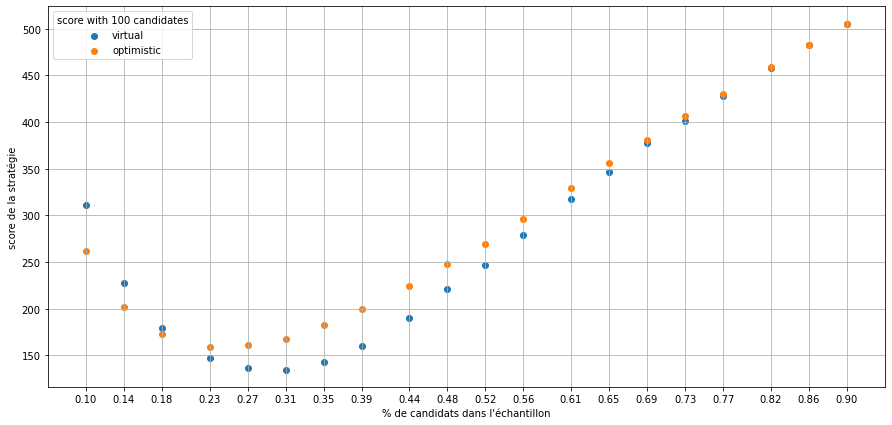

In [42]:
from tqdm import tqdm
number_of_candidates = 100
k = 10
n_sim = 10000

print(f"on se place dans le cas où on sélectionne {k} candidats parmi {number_of_candidates}")
print(f"on effectue {n_sim} simulations")

props = [np.round(prop, 2) for prop in list(np.linspace(k / number_of_candidates, 1 - k / number_of_candidates, num = 20))]
score_virtual = []
score_optimistic = []
for prop in tqdm(props, "processing through props"):
    sim_virtual = np.array([sum(virtual_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(n_sim)])
    score_virtual.append(np.mean(sim_virtual))
    sim_optimistic = np.array([sum(optimistic_choose_k_candidates(generate_candidates(number_of_candidates), prop, k)) for i in range(n_sim)])
    score_optimistic.append(np.mean(sim_optimistic))

plt.figure(figsize = (15, 7))
plt.scatter(props, score_virtual, label = "virtual")
plt.scatter(props, score_optimistic, label = "optimistic")
plt.xticks(props)
plt.xlabel("% de candidats dans l'échantillon")
plt.ylabel("score de la stratégie")
plt.legend(title = f'score with {number_of_candidates} candidates')
plt.grid(True)
plt.show()

**TO DO** : calculer le competitive ratio des différentes stratégies et vérifier empiriquement qu'ils sont $\exp$-competitive pour une taille d'échantillon $\lfloor \frac{n}{\exp} \rfloor$.

Given a request sequence $\sigma$, let $C_{A}(\sigma)$ denote the cost incurred by algorithm $A$ and let $C_{OPT}(\sigma)$ denote the cost incurred by the optimal onine algorithm (OPT). The algorithm $A$ is called $c$-competitive if there exists a constant $\alpha$ such that :

$$C_{A}(\sigma) \leq c * C_{OPT}(\sigma) + \alpha$$

for all request sequences $\sigma$.

## 3. Problème du secrétaire sous contraintes

On s'intéresse désormais au **problème du secrétaire avec contraintes**. On ajoute au problème du secrétaire une contrainte (ou plus exactement un bonus) de parité. Dans le cas  $k = 2$ que nous traitons ici, cela signifie que l'entreprise reçoie un bonus si les candidats sélectionnées sont un homme et une femme. Ainsi la fonction à minimiser n'est plus uniquement la somme de la valeur des deux candidats mais prend en compte également leur sexe. 
Nous regardons tout d'abord les résultats de score de parité que l'on obtient lorsque applique la stratégie virtual explicité auparavant. 
Ensuite nous cherchons à adapter la stratégie virtual pour prendre en compte le bonus de parité. 


*Disclaimer : on part du principe que les entreprises discriminent plus les femmes que les hommes, ceci étant le cas dans la plupart des secteurs (mais pas tous)* G PAS COMPRIS KESKETUVOULE DIR

Nous faisons attention à **ne pas avoir le cas où l’entreprise traite deux problèmes indépendants**.
Par exemple, si on cherche à recruter x femmes parmi k recrutements, on recrute séparément les (k-x) hommes et les femmes.
En revanche, les problèmes "au moins x femmes parmi k recrutements" ou de bonus parité (ou de pénalité) permettent d'avoir une dépendance dans la sélection : si je recrute un homme alors je dois recruter plus de femmes par la suite, ou inversement si je recrute une femme alors je peux recruter plus d'hommes par la suite.

**TO DO** :

1) **Tester différentes distributions hommes / femmes** :
- tirage binomial (paramètre p = proportion de femmes, n = nombre de candidats) ;
- 1--50 pour H et 5--40 pour femmes ;
- distribution gaussienne.

2) **Tester deux stratégies** pour le choix du premier candidat + comparer les competitive ratio.

3) **Faire varier le bonus parité** et observer les courbes de pourcentage de femmes retenues p/r au pourcentage de femmes parmi les candidats (doit être de plus en plus flat à mesure que le bonus augmente).

4) **Essayer d'autres fonction d'utilité convexes** pour l'entreprise (exemple : type Cobb Douglas qui valorise la diversité).

**1) Fonction qui génère des candidats avec gender** :

In [43]:
import pandas as pd

def generate_candidates_gender(n, prop = 0.4):
    candidates = np.arange(1, n + 1)
    np.random.shuffle(candidates)
    candidates = list(candidates)
    gender = list(np.random.binomial(1, prop, n))
    #candidates = [[candidate, gender] for candidate, gender in zip(candidates, gender)]
    candidates = pd.DataFrame((zip(candidates, gender)), columns = ['candidate', 'gender'])
    return candidates

La répartiation des femmes dans les canddiats suit donc une binomiale de paramètre (prop,n). Cettre distribution est censée représenter le fait que les femmes soient largement sous représentée dans certaines catégories professionelles (parmi les ingénieurs par exemple), ainsi moins de femmes se présentent aux entretiens. 

**2) Stratégie virtual sans bonus parité** :

In [44]:
prop_women = 0.3
k = 20
prop = 0.37
candidates = generate_candidates_gender(100, prop_women)
prop_women_amongst_best = sum(candidates.sort_values(by = "candidate")["gender"][:k]) / k
best_possible_score = sum(candidates.sort_values(by = "candidate")["candidate"][:k])
chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
score = sum(chosen_candidates)
print(f"score = {score} vs. best possible score = {best_possible_score} ") 

def parity_score(candidates, chosen_candidates):
    chosen_genders = []
    for i in range(len(candidates)):
        if candidates['candidate'][i] in chosen_candidates:
            chosen_genders.append(candidates['gender'][i])
    parity_score = np.sum(chosen_genders) / len(chosen_genders)
    return float(parity_score)

parity_score_sim = parity_score(candidates, chosen_candidates)
print(f"parity_score is {parity_score_sim} when prop of women is {prop_women} and when prop of women amongst top {k} is {prop_women_amongst_best}")

score = 432 vs. best possible score = 210 
parity_score is 0.3 when prop of women is 0.3 and when prop of women amongst top 20 is 0.3


Dans le cas sans bonus parité, on remarque que le score de parité est proche de la proportion de femme qu'on a choisit. On teste ensuite cette méthode pour différents pourcentage de femme parmi les candidats initiaux. 

100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


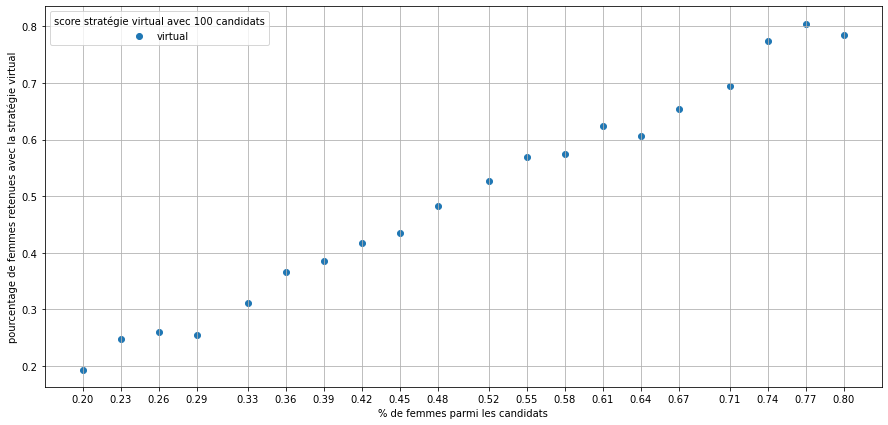

In [45]:
from tqdm import tqdm
k = 2
prop = 0.37
props_women = [np.round(prop, 2) for prop in list(np.linspace(0.2, 0.8, num = 20))]

parity_score_virtual = []
for prop_women in tqdm(props_women):
    sim_parity_virtual = []
    for i in range(300):
        candidates = generate_candidates_gender(100, prop_women)
        chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
        sim_parity_virtual.append(parity_score(candidates, chosen_candidates))
    mean_parity_score_virtual = sum(sim_parity_virtual) / len(sim_parity_virtual)
    parity_score_virtual.append(mean_parity_score_virtual)
    
plt.figure(figsize = (15, 7))
plt.scatter(props_women, parity_score_virtual, label = "virtual")
plt.xticks(props_women)
plt.xlabel("% de femmes parmi les candidats")
plt.ylabel("pourcentage de femmes retenues avec la stratégie virtual")
plt.legend(title = f'score stratégie virtual avec {number_of_candidates} candidats')
plt.grid(True)
plt.show()

On observe une relation linéaire : la parité n'est pas incitée et dépends donc uniquement de la distribution intiale des candidats. Ainsi le processus de recrutement reproduit la non-parité des candidats. 

3) **Stratégie avec bonus parité** :

**Explication de la stratégie virtual adaptée pour $k = 2$ et $n$ candidats** :

Soit la fonction objectif convexe $F$ (somme des rangs +bonus $*\mathbb{1}(parité)$ ) et $n$ candidats

1) On retient d'abord dans notre échantillon de taille $k$  $E = (z_{1} ... z_{k})$ le couple $(x^{\star},y^{\star})$ qui minimise $F(x,y)$, $\forall$ $(x,y) \in E$ et tel que $x^{\star} \leq y^{\star}$.

2) On choisit le premier candidat en tenant compte uniquement de son rang, donc en appliquant la stratégie virtual classique. On note $k0$ son rang. Si $k0$=n ,$res=(z_{i},y^{\star})$. 

3) En revanche, si $i0$ < n, on parcourt les candidats restant $R = (z_{i0} ... z_{n})$ pour trouver le deuxième candidat retenu dans $res$: 
- pour chaque candidat $z_{i}$, on cherche  $ min( F(x^{\star},y^{\star}) ,  F(z_{i},y^{\star}) , F(x^{\star},z_{i}) )$. 
- si $F(z_{i},y^{\star})$ est le mininum alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(z_{1}^{\star},y^{\star}), max(z_{1}^{\star},y^{\star}) ) $ ;
    - on passe à $z_{i+1}$
- si $F(x^{\star},z_{i})$ est le mininum alors :
    - on retient $z_{1}^{\star} = z_{i}$ que l'on ajoute à $res$;
    - on pose le couple $( min(x^{\star},z_{1}^{\star}), max(x^{\star},z_{1}^{\star}) ) $ ;
    - on passe à $z_{i+1}$
- sinon, on passe à directement $z_{k0+1}$


On définit notre fonction objectif comme la somme des rangs des candidats avec un bonus en cas de parité.

In [157]:
def objective_function(selected_candidates, bonus):
    candidate = selected_candidates['candidate']
    if sum(selected_candidates['gender']) == len(selected_candidates) / 2:
        return sum(candidate) - bonus
    else:
        return sum(candidate)

On cherche les meilleurs candidats de notre échantillon i.e. les candidats qui minimisent la fonction objectif.
Pour ce faire, on définit au préalable deux fonctions :
- find_best_from_samplev1 qui parcourt toutes les combinaisons possibles de variables
- find_best_from_samplev2 qui dans le cas $k = 2$ ne se penche que sur quelques résultats.

Dans le cas $k = 2$, la fonction find_best_from_samplev2 permet de faire aussi rapidement les calculs pour 1000 candidats que pour 100 (contrairement à find_best_from_samplev1).

In [207]:
from itertools import combinations

def find_best_from_samplev1(sample, k, bonus):
    possibilities = list(combinations(list(sample.index), k))
    #print(f"number of possibilities for best_from_sample = {len(possibilities)}")
    best_from_sample = sample.iloc[list(possibilities[0])]
    best_score = objective_function(best_from_sample, bonus)
    for possibility in tqdm(possibilities, "processing through combinations", disable = True):
        if objective_function(sample.iloc[list(possibility)], bonus) < objective_function(best_from_sample, bonus):
            best_from_sample = sample.iloc[list(possibility)]
            best_score_sample = objective_function(best_from_sample, bonus)
    #print(f"best_score_sample is {best_score_sample}")
    return best_from_sample.sort_values(by = "candidate").reset_index(drop = True)

def find_best_from_samplev2(sample, k, bonus):
    
    if len(sample) < 2:
        return "veuillez saisir un nombre de candidat ou une taille d'échantillon plus grands"
    
    if k == 2:
        sorted_sample = sample.sort_values(by = 'candidate').reset_index(drop = True)
        if sorted_sample["gender"][0] != sorted_sample["gender"][1]:
            return sorted_sample.iloc[[0,1]]
        else:
            nb_women = sorted_sample["gender"].sum()
            nb_men = len(sample) - nb_women
            if (nb_women == 0) or (nb_men == 0):
                return sorted_sample.iloc[[0,1]]
            else:
                women_sample = sorted_sample[sorted_sample["gender"] == 1].reset_index(drop = True)
                men_sample = sorted_sample[sorted_sample["gender"] == 0].reset_index(drop = True)
                mix_score = women_sample.iloc[0]["candidate"] + men_sample.iloc[0]["candidate"] - bonus
                if nb_women >= 2:
                    women_score = women_sample.iloc[0]["candidate"] + women_sample.iloc[1]["candidate"]
                    if nb_men >= 2:
                        men_score = men_sample.iloc[0]["candidate"] + men_sample.iloc[1]["candidate"]
                        min_score = min(mix_score, women_score, men_score)
                        if min_score == mix_score:
                            best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                            best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                            return pd.concat([best_woman_df,best_man_df])
                        elif min_score == women_score:
                            return women_sample.iloc[[0,1]]
                        else:
                            return men_sample.iloc[[0,1]]
                    else:
                        min_score = min(mix_score, women_score)
                        if min_score == mix_score:
                            best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                            best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                            return pd.concat([best_woman_df,best_man_df])
                        else:
                            return women_sample.iloc[[0,1]]
                else:
                    men_score = men_sample.iloc[0]["candidate"] + men_sample.iloc[1]["candidate"]
                    min_score = min(mix_score, men_score)
                    if min_score == mix_score:
                        best_woman_df = pd.DataFrame(women_sample.iloc[0]).transpose()
                        best_man_df = pd.DataFrame(men_sample.iloc[0]).transpose()
                        return pd.concat([best_woman_df,best_man_df])
                    else:
                        return men_sample.iloc[[0,1]]
    else:
        possibilities = list(combinations(list(sample.index), k))
        #print(f"number of possibilities for best_from_sample = {len(possibilities)}")
        best_from_sample = sample.iloc[list(possibilities[0])]
        best_score = objective_function(best_from_sample, bonus)
        for possibility in tqdm(possibilities, "processing through combinations", disable = True):
            if objective_function(sample.iloc[list(possibility)], bonus) < objective_function(best_from_sample, bonus):
                best_from_sample = sample.iloc[list(possibility)]
                best_score_sample = objective_function(best_from_sample, bonus)
        #print(f"best_score_sample is {best_score_sample}")
        return best_from_sample.sort_values(by = "candidate").reset_index(drop = True)

On code notre stratégie virtual tenant compte du genre.
Comme expliqué auparavant, notre stratégie sélectionne le premier candidat en tenant compte uniquement de son rang et pas de son genre.

In [218]:
def virtual_choose_k_candidates_gender(candidates, prop, k, bonus):
    
    if k <= 1:
        return "please select a greater number of candidates to choose for the k-secretary problem"
    
    # best_from_sample
    sample_size = int(round(len(candidates) * prop))
    sample = candidates.iloc[list(range(sample_size))]
    best_from_sample = find_best_from_samplev2(sample, k, bonus) # DataFrame
    #print("best_from_sample :")
    #display(best_from_sample)
    
    # select best candidates
    other_candidates = candidates.iloc[list(range(sample_size, len(candidates)))].reset_index(drop = True)
    #print("10 premiers candidats hors échantillon")
    #display(other_candidates[:10])
    chosen_candidates = pd.DataFrame(columns = ["candidate", "gender"])
    remaining_candidates = len(other_candidates)
    
    for index in tqdm(range(len(other_candidates)), disable = True):
        
        # choix du premier candidat : on sélectionne le meilleur
        if len(chosen_candidates) < 1:
            # s'il reste encore suffisamment de candidats à observer : on continue à chercher le meilleur
            if remaining_candidates > k - len(chosen_candidates):
                # si le candidat est meilleur que le pire des candidats sélectionnés dans l'échantillon
                # alors on le sélectionne, sinon on continue à chercher
                remaining_candidates -= 1
                if other_candidates["candidate"][index] < list(best_from_sample["candidate"])[-1]:
                    chosen_candidates = pd.concat([chosen_candidates,pd.DataFrame(other_candidates.iloc[index]).transpose()], ignore_index = True)
                    #print("first chosen candidate")
                    #display(chosen_candidates)
                    # stratégie virtual
                    best_from_sample.loc[len(best_from_sample) - 1] = chosen_candidates.loc[len(chosen_candidates) - 1]
                    best_from_sample = best_from_sample.sort_values(by = "candidate").reset_index(drop = True)
                    #print("modified best_from_sample")
                    #display(best_from_sample)
            # s'il n'y a plus assez de candidats à observer : on sélectionne tous les derniers
            else:
                #print("remaining_candidates :")
                #print(remaining_candidates)
                #print("a")
                return pd.concat([chosen_candidates, other_candidates.iloc[range(len(other_candidates) - k, len(other_candidates))]], ignore_index=True)
        
        # le premier candidat a été choisi : on sélectionne les suivants
        else:
            if remaining_candidates > k - len(chosen_candidates):
                if len(chosen_candidates) == k:
                    #print("remaining_candidates :")
                    #print(remaining_candidates)
                    #print("b")
                    return chosen_candidates
                else:
                    remaining_candidates -= 1
                    # on applique la stratégie virtual avec la fonction objectif 
                    saved_index = -1
                    for index_sample in range(len(best_from_sample)):
                        aux = best_from_sample.copy()
                        aux.loc[index_sample] = other_candidates.loc[index]
                        if objective_function(aux, bonus) < objective_function(best_from_sample, bonus):
                            saved_index = index_sample
                    if saved_index >= 0:
                        chosen_candidates = pd.concat([chosen_candidates,pd.DataFrame(other_candidates.iloc[index]).transpose()], ignore_index = True)
                        best_from_sample.loc[saved_index] = other_candidates.loc[index]
                        best_from_sample = best_from_sample.sort_values(by = "candidate").reset_index(drop = True)
                        #print("modified best_from_sample")
                        #display(best_from_sample)

            else:
                #print("remaining_candidates :")
                #print(remaining_candidates)
                #print("c")
                return pd.concat([chosen_candidates, other_candidates.iloc[range(len(other_candidates) - len(chosen_candidates), len(other_candidates))]], ignore_index=True)
    #print("remaining_candidates :")
    #print(remaining_candidates)
    #print("d")    
    return chosen_candidates

In [246]:
candidates = generate_candidates_gender(100, prop_women)
prop = 0.4
k = 2
bonus = 10
virtual_choose_k_candidates_gender(candidates, prop, k, bonus)

,candidate,gender
0,2,0
1,44,1


processing through props_women: 100%|██████████| 10/10 [02:40<00:00, 16.10s/it]


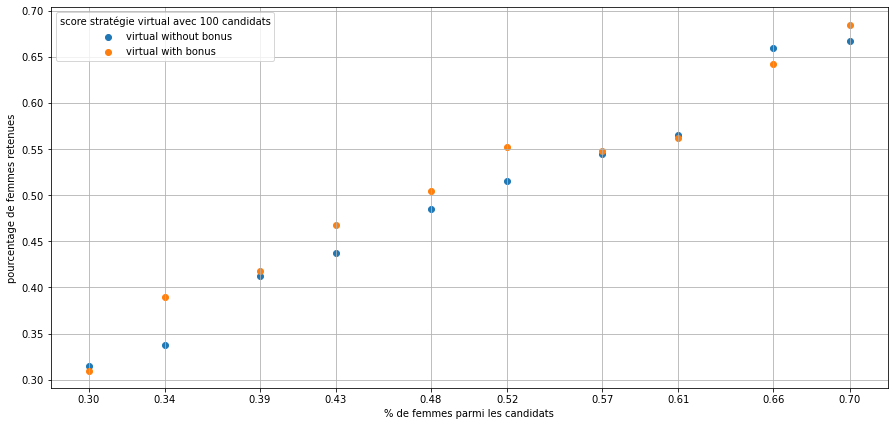

In [249]:
k = 2
prop = 0.37
props_women = [np.round(prop, 2) for prop in list(np.linspace(0.3, 0.7, num = 10))]

parity_score_virtual = []
parity_score_virtual_bonus = []
for prop_women in tqdm(props_women, "processing through props_women"):
    sim_parity_virtual = []
    sim_parity_virtual_bonus = []
    for i in range(200):
        candidates = generate_candidates_gender(1000, prop_women)
        chosen_candidates = virtual_choose_k_candidates(candidates['candidate'].values, prop, k)
        sim_parity_virtual.append(parity_score(candidates, chosen_candidates))
        chosen_candidates_bonus = virtual_choose_k_candidates_gender(candidates, prop, k, bonus)
        sim_parity_virtual_bonus.append(np.mean(chosen_candidates_bonus['gender'].values))
    mean_parity_score_virtual = sum(sim_parity_virtual) / len(sim_parity_virtual)
    parity_score_virtual.append(mean_parity_score_virtual)
    mean_parity_score_virtual_bonus = sum(sim_parity_virtual_bonus) / len(sim_parity_virtual_bonus)
    parity_score_virtual_bonus.append(mean_parity_score_virtual_bonus)
    
plt.figure(figsize = (15, 7))
plt.scatter(props_women, parity_score_virtual, label = "virtual without bonus")
plt.scatter(props_women, parity_score_virtual_bonus, label = "virtual with bonus")
plt.xticks(props_women)
plt.xlabel("% de femmes parmi les candidats")
plt.ylabel("pourcentage de femmes retenues")
plt.legend(title = f'score stratégie virtual avec {number_of_candidates} candidats')
plt.grid(True)
plt.show()

On observe une meilleure parité avec la stratégie avec bonus ! 

## 4. Ressources

- https://medium.com/intriguing-algorithms/thirty-seven-percent-rule-b13c41d83588 : explication du problème du secrétaire
- https://www.imrankhan.dev/pages/Solving%20the%20secretary%20problem%20with%20Python.html : simulation du problème du secrétaire
- https://docs.microsoft.com/fr-fr/archive/msdn-magazine/2016/september/test-run-the-secretary-problem : simulation du problème du secrétaire (en C#)
- https://github.com/RoyZhang7/secretary-problem : simulation problème du secrétaire
- https://github.com/fgreve/at/blob/master/_R/2016-08-03-secretary.Rmd : simulation problème du secrétaire avec R
- https://arxiv.org/pdf/1905.04941.pdf : article intéressant (cardinality constraint)
- https://drops.dagstuhl.de/opus/volltexte/2019/11514/pdf/LIPIcs-ISAAC-2019-18.pdf : k-secretary problem
- https://www.sigecom.org/exchanges/volume_8/2/buchbinder.pdf : one-to-one correspondence between mechanisms for the secretary problem and feasible solutions to the linear program